# Bayesian Neural Networks (BNNs)




In [1]:
#import necessary libraries
import json
import pandas as pd
import math as m
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn
from torch.utils.data import DataLoader, TensorDataset




## 1.  Data Import 

Data is imported from the defined csv file to a pandas Data Frame.

In [2]:
####### load values #######

data_batch='1001_1002_1003'
train_df = pd.read_csv("trainingData/1001_1002_1003_CFB_xy_train.csv")
val_df = pd.read_csv("trainingData/1001_CFB_xy_validation.csv")
test_df = pd.read_csv("trainingData/1001_CFB_xy_test.csv")




In [3]:
train_df

,Unnamed: 0,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G,eta_min_c,eta_min_s,eta_min_shear
0,0,7316.767442,9858.693527,670.111910,296.960109,4578.954788,19.123075,23.414408,29.351365,437.575707,14.570059,20.392475,329.743669,26.216140,0.841518,-0.899371,763.083525,0.971350,0.999918,0.255641
1,1,4109.497290,10040.817949,216.866461,627.347199,2757.955442,25.327086,13.852833,28.445230,376.195192,22.440791,14.785867,156.659807,45.467104,0.357328,-17.686199,480.888478,2.988712,0.999900,0.478011
2,2,6481.214774,19642.425351,630.452453,808.700433,3575.074819,20.018548,15.454918,20.991629,235.775667,17.670412,20.880608,159.539665,31.003168,0.588936,47.460891,300.381370,14.358522,2.190585,2.100074
3,3,4983.830508,5045.232703,813.243489,281.592574,3852.597077,25.990575,13.490555,19.389877,179.930373,10.911357,23.134080,229.052153,49.855574,0.615093,0.413577,671.177680,3.832633,1.029085,0.178855
4,4,11350.654319,14992.112972,915.516826,996.779574,2742.346227,24.762013,25.404220,18.919854,404.169200,16.415385,12.309846,236.947986,39.761843,0.666640,13.325371,575.321280,7.989916,1.485492,0.950330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6385,6838,7292.481726,2630.929558,500.384132,365.346225,2099.483844,22.511029,23.139504,22.873908,144.227288,11.349843,19.782584,346.978847,34.589178,0.835711,-27.874869,520.826358,2.171281,1.011887,0.433113
6386,6840,8094.059731,12028.432802,360.563532,683.659168,2651.087277,26.445904,11.030083,25.111461,261.108592,16.060830,26.952644,435.715078,49.261283,0.104358,45.371711,944.729841,1.787798,0.998492,0.117897
6387,6841,6867.661205,19716.650866,236.612677,1231.230380,4223.863628,14.351139,26.322388,19.703159,503.726652,20.077918,23.156073,437.503691,43.620750,0.652775,11.149412,769.333947,0.906973,0.999184,0.139870
6388,6842,10821.158745,2459.541545,505.002233,376.288504,4798.753440,29.130015,17.164455,24.657522,262.883424,21.006850,27.708275,82.557592,30.096884,0.450170,24.083232,1080.477264,1.615063,0.998288,0.068358


In [4]:


# Select features
x_names = ['L', 'b1',  't_p', 't_w', 'h_w', 'd1_plate', 'd4_plate', 'd2_plate', 's_plate', 'd1_walls', 'd4_walls', 's_walls', 'fcc', 's', 'beta', 'h_G'] # all 16 features
# Select target(s)
y_names=['eta_min_s']

x_train_df = train_df[x_names]
y_train_df = train_df[y_names]
x_val_df = val_df[x_names]
y_val_df = val_df[y_names]
x_test_df = test_df[x_names]
y_test_df = test_df[y_names]

# transfrom to numpy arrays
x_train_np = x_train_df.values
y_train_np = y_train_df.values
x_val_np = x_val_df.values
y_val_np = y_val_df.values
x_test_np = x_test_df.values
y_test_np = y_test_df.values

#Print shapes of the splitted data sets
print('Training Dataset: ',x_train_df.shape,y_train_df.shape )
print('Validation Dataset: ',x_val_df.shape, y_val_df.shape)
print('Test Dataset: ',x_test_df.shape,y_test_df.shape)



####### needed for the scaler #######
x_data_df = pd.concat([x_train_df, x_val_df, x_test_df], axis=0, ignore_index=True)
print('Total Dataset: ',x_data_df.shape )
total_data_set_size=x_data_df.shape[0]

Training Dataset:  (6390, 16) (6390, 1)
Validation Dataset:  (962, 16) (962, 1)
Test Dataset:  (1202, 16) (1202, 1)
Total Dataset:  (8554, 16)


## 2. Pre-process Data

Pre-Processing Steps
- select x and y columns (inputs and outputs)
- split data set in trianing and test set
- transform data to same range with MinMaxScaler
- transform scaled data to troch tensors

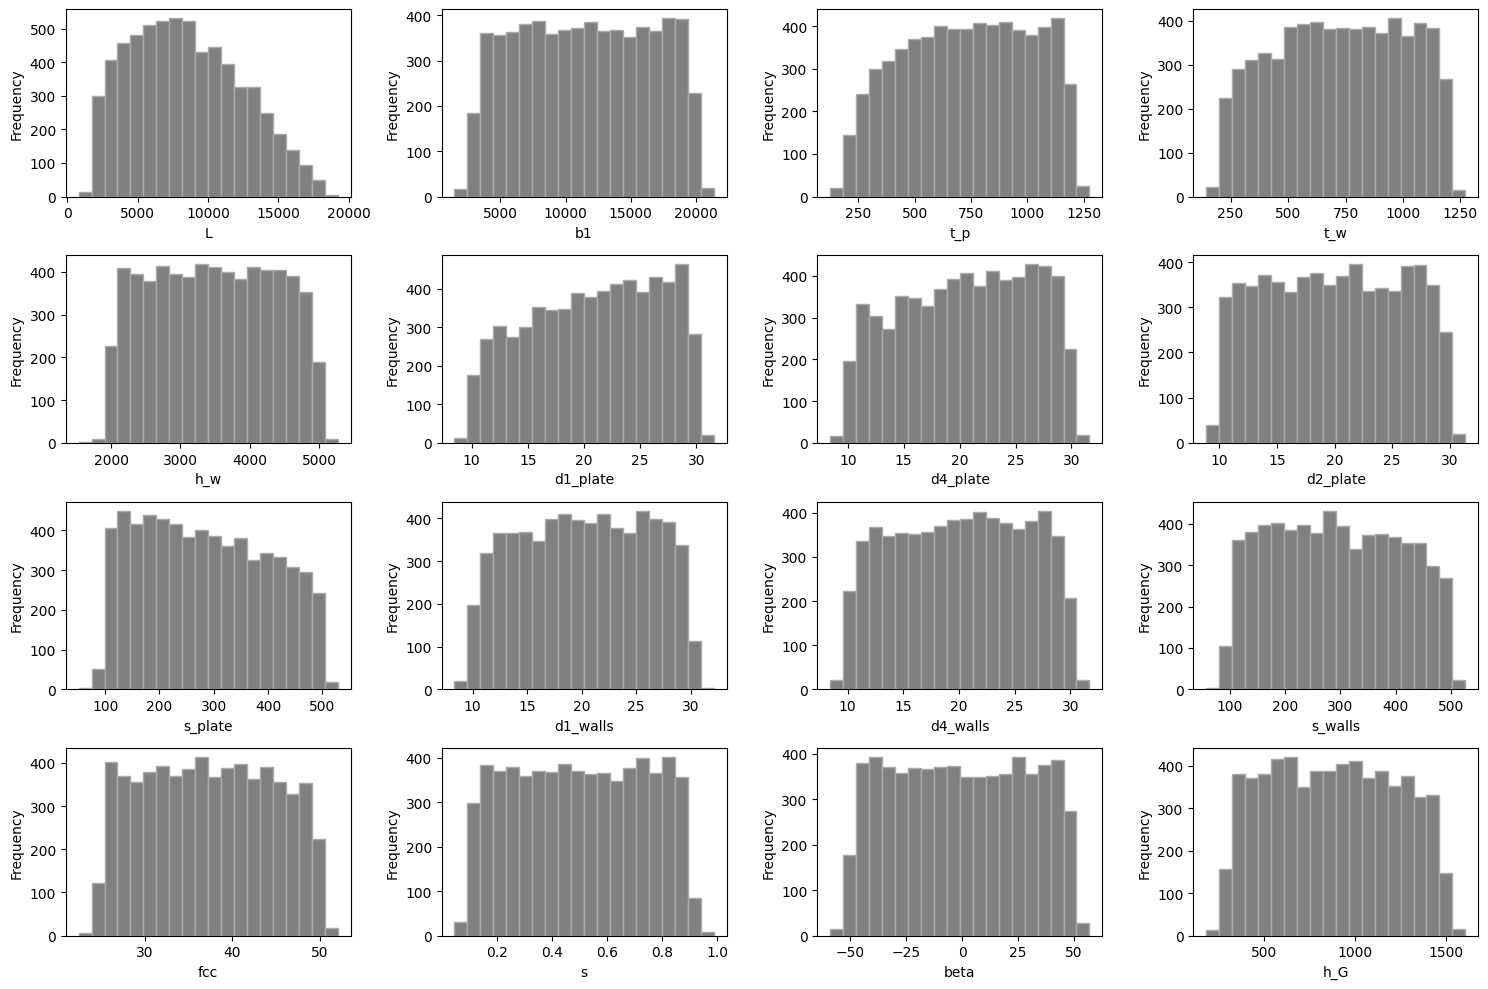

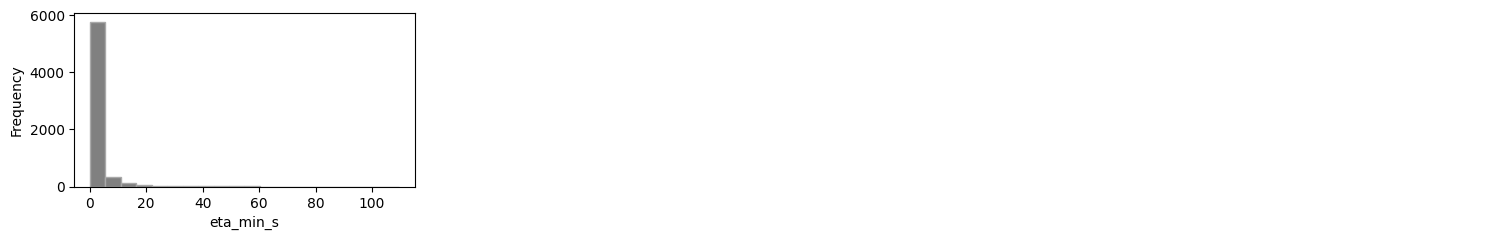

In [5]:
from plotting import hist_matrix
hist_matrix(x_train_df)
hist_matrix(y_train_df)

In [6]:
###### Scaling of data ######

# INPUT we scale to a range 0,1
# Initialize the MinMaxScaler and fit it on the training data
# Note: MinMaxScaler  scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.
# Note: MinMaxScaler doesn’t reduce the effect of outliers, but it linearly scales them down into a fixed range
# Note: MinMaxScaler is sufficient as our data is uniformily distributed for the case when we have non-uniform distirbuted data (as sampled with )

#initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# fit scaler on total data set
scaler.fit(x_data_df)

# scale training data
x_train_scaled_np = scaler.transform(x_train_df)
x_train_scaled_df=pd.DataFrame(data=x_train_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_val_scaled_np = scaler.transform(x_val_df)
x_val_scaled_df=pd.DataFrame(data=x_val_scaled_np, columns=scaler.get_feature_names_out())

# Scale the validation data using the same scaler
x_test_scaled_np = scaler.transform(x_test_df)
x_test_scaled_df=pd.DataFrame(data=x_test_scaled_np, columns=scaler.get_feature_names_out())

#plot scaled data
x_train_scaled_df.describe()

,L,b1,t_p,t_w,h_w,d1_plate,d4_plate,d2_plate,s_plate,d1_walls,d4_walls,s_walls,fcc,s,beta,h_G
count,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000,6390.000000
mean,0.415495,0.506200,0.529696,0.516522,0.520477,0.538362,0.523458,0.495844,0.488939,0.499127,0.505126,0.502811,0.502508,0.484397,0.506549,0.492128
std,0.211955,0.249206,0.241755,0.247641,0.231385,0.246179,0.246705,0.257305,0.241203,0.240128,0.247971,0.243358,0.243815,0.248703,0.253079,0.240827
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.243588,0.291906,0.332464,0.314526,0.320308,0.336437,0.317310,0.273541,0.281327,0.295519,0.293597,0.294216,0.293180,0.269763,0.287704,0.284334
50%,0.397301,0.505760,0.537985,0.521730,0.518824,0.554046,0.534811,0.496987,0.474742,0.501949,0.511408,0.494456,0.498634,0.482650,0.502191,0.493189
75%,0.570802,0.723482,0.736202,0.728013,0.719774,0.752311,0.735745,0.722166,0.691609,0.707330,0.717054,0.708527,0.710452,0.701978,0.727111,0.693674
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
##### convert to troch tensors ######

# convert data to toch tensors (as needed format for BNN model)
#training data
x_train_scaled_tensor=torch.tensor(x_train_scaled_df.values, dtype=torch.float32)
y_train_tensor=torch.tensor(y_train_df.values, dtype=torch.float32)

#validation data
x_val_scaled_tensor=torch.tensor(x_val_scaled_df.values, dtype=torch.float32)
y_val_tensor=torch.tensor(y_val_df.values, dtype=torch.float32)

#test data
x_test_scaled_tensor=torch.tensor(x_test_scaled_df.values, dtype=torch.float32)
y_test_tensor=torch.tensor(y_test_df.values, dtype=torch.float32)


## 3. Setup and Train Model

- Define NN Architecture
- Define Losses
- Trianing Loop
- Plot loss developement during trianing
- save trained model

In [152]:
class wMSELoss(nn.Module):
    def __init__(self, importance_range=(0, 5), weight=10):
        """
        Initializes the weighted MSE loss function with a specified importance range and high weight.
        
        Parameters:
        importance_range (tuple): The range of target values that should receive higher weighting.
        high_weight (float): The weight to apply to errors within the importance range.
        """
        super(wMSELoss, self).__init__()
        self.importance_range = importance_range
        self.weight = weight

    def forward(self, predictions, targets):
        """
        Computes the weighted mean squared error loss.
        
        Parameters:
        predictions (Tensor): The predicted values from the model.
        targets (Tensor): The actual target values.
        
        Returns:
        Tensor: The computed weighted MSE loss.
        """
        # Calculate the basic MSE loss
        basic_mse = (predictions - targets) ** 2

        # Apply a weight to errors within the specified range
        weights = torch.ones_like(targets)
        weights[(targets >= self.importance_range[0]) & (targets <= self.importance_range[1])] = self.weight

        # Calculate the weighted MSE loss
        weighted_mse = basic_mse * weights
        return weighted_mse.mean()
    

class RMSELoss(nn.Module):

    def __init__(self):
        """
        Initializes the RMSE loss function.
        """
        super(RMSELoss, self).__init__()

    def forward(self, predictions, targets):
        """
        Computes the root mean squared error loss.

        Parameters:
        predictions (Tensor): The predicted values from the model.
        targets (Tensor): The actual target values.

        Returns:
        Tensor: The computed RMSE loss.
        """
        # Calculate the Mean Squared Error (MSE)
        mse = torch.mean((predictions - targets) ** 2)
        # Take the square root to compute the RMSE
        rmse = torch.sqrt(mse)
        return rmse
    

import torch.distributions as dist

class TCELoss(nn.Module):
    def __init__(self, n_confidence_levels=20):
        """
        Initializes the TCE loss function.
        
        Parameters:
        n_confidence_levels (int): The number of confidence levels to evaluate for calibration error.
        """
        super(TCELoss, self).__init__()
        self.n_confidence_levels = n_confidence_levels

    def forward(self, y_pred_mean, pred_std, y_true):
        """
        Computes the Total Calibration Error (TCE) loss.
        
        Parameters:
        y_pred_mean (Tensor): The mean predictions from the model.
        pred_std (Tensor): The predicted standard deviations (uncertainty) from the model.
        y_true (Tensor): The actual target values.
        
        Returns:
        Tensor: The computed TCE loss.
        """
        expected_confidence_levels, observed_confidence_levels = self.evaluate_confidence_levels(y_true, y_pred_mean, pred_std)
        ece, tce, bias = self.calc_uncertainty_calibration_metrics(expected_confidence_levels, observed_confidence_levels)
        return tce  # Return the TCE as a tensor directly involved in the graph

    def evaluate_confidence_levels(self, y_true, y_pred_mean, pred_std):
        """
        Evaluates the observed confidence levels for a range of expected confidence levels.
        
        Parameters:
        y_true (Tensor): The true values.
        y_pred_mean (Tensor): The predicted means.
        pred_std (Tensor): The predicted standard deviations (uncertainty).
        
        Returns:
        expected_confidence_levels (Tensor): The expected confidence levels (torch tensor).
        observed_confidence_levels (Tensor): The observed confidence levels (torch tensor).
        """
        expected_confidence_levels = torch.linspace(0, 1, self.n_confidence_levels, device=y_true.device)
        observed_confidence_levels = torch.zeros_like(expected_confidence_levels)

        # Loop through each confidence level
        for i, confidence_level in enumerate(expected_confidence_levels):
            z = dist.Normal(0, 1).icdf((1 + confidence_level) / 2)  # Get z-score for confidence level
            
            # Calculate the prediction intervals
            lower_bound = y_pred_mean - z * pred_std
            upper_bound = y_pred_mean + z * pred_std
            
            # Check if true values fall within these bounds
            within_interval = ((lower_bound <= y_true) & (y_true <= upper_bound)).float()
            coverage = within_interval.mean()  # Proportion of true values in the interval
            observed_confidence_levels[i] = coverage
        
        return expected_confidence_levels, observed_confidence_levels

    def calc_uncertainty_calibration_metrics(self, expected_confidence_levels, observed_confidence_levels):
        """
        Calculates the Total Calibration Error (TCE), Expected Calibration Error (ECE), and bias.
        
        Parameters:
        expected_confidence_levels (Tensor): The expected confidence levels.
        observed_confidence_levels (Tensor): The observed confidence levels.
        
        Returns:
        ece (Tensor): Expected Calibration Error.
        tce (Tensor): Total Calibration Error.
        bias (Tensor): Calibration bias.
        """
        # Calculate Expected Calibration Error (ECE)
        ece = torch.mean(torch.abs(expected_confidence_levels - observed_confidence_levels))

        # Calculate Total Calibration Error (TCE)
        tce = torch.sum(torch.abs(expected_confidence_levels - observed_confidence_levels))

        # Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
        bias = torch.sum(expected_confidence_levels - observed_confidence_levels)

        return ece, tce, bias
    

class UncertaintyCalibrationLoss(nn.Module):
    def __init__(self):
        super(UncertaintyCalibrationLoss, self).__init__()

    def forward(self, y_pred_mean, pred_std, y_true):
        """
        Computes a proxy calibration loss by comparing the predicted standard deviations
        to the actual residual errors, encouraging the model's uncertainty to match
        the true error distribution.
        
        Parameters:
        y_pred_mean (Tensor): The mean predictions from the model.
        pred_std (Tensor): The predicted standard deviations (uncertainty) from the model.
        y_true (Tensor): The actual target values.
        
        Returns:
        Tensor: The computed proxy calibration loss.
        """
        # Calculate the residuals (absolute error between predictions and actuals)
        residual = torch.abs(y_pred_mean - y_true)

        # Penalize the difference between the predicted uncertainty (pred_std)
        # and the actual error (residual), encouraging the uncertainty to match
        calibration_loss = torch.mean((pred_std - residual) ** 2)

        return calibration_loss


class OLDTCELoss(nn.Module):
    def __init__(self, n_confidence_levels=20):
        """
        Initializes the TCE loss function.
        
        Parameters:
        n_confidence_levels (int): The number of confidence levels to evaluate for calibration error.
        """
        super(TCELoss, self).__init__()
        self.n_confidence_levels = n_confidence_levels

    def forward(self, y_pred_mean, pred_std, y_true):
        """
        Computes the Total Calibration Error (TCE) loss.
        
        Parameters:
        y_pred_mean (Tensor): The mean predictions from the model.
        pred_std (Tensor): The predicted standard deviations (uncertainty) from the model.
        y_true (Tensor): The actual target values.
        
        Returns:
        Tensor: The computed TCE loss.
        """
        expected_confidence_levels, observed_confidence_levels = self.evaluate_confidence_levels(y_true, y_pred_mean, pred_std)
        _, tce, _ = self.calc_uncertainty_calibration_metrics(expected_confidence_levels, observed_confidence_levels)
        return torch.tensor(tce, requires_grad=True)

    def evaluate_confidence_levels(self, y_true, y_pred_mean, pred_std):
        """
        Evaluates the observed confidence levels for a range of expected confidence levels.
        
        Parameters:
        y_true (Tensor): The true values.
        y_pred_mean (Tensor): The predicted means.
        pred_std (Tensor): The predicted standard deviations (uncertainty).
        
        Returns:
        expected_confidence_levels (np.ndarray): The expected confidence levels.
        observed_confidence_levels (list): The observed confidence levels.
        """
        expected_confidence_levels = np.linspace(0, 1, self.n_confidence_levels)
        observed_confidence_levels = []

        # Convert tensors to numpy arrays for calculations
        y_pred_mean_np = y_pred_mean.detach().cpu().numpy()
        pred_std_np = pred_std.detach().cpu().numpy()
        y_true_np = y_true.detach().cpu().numpy()

        # Compute prediction intervals and observed confidence levels
        for confidence_level in expected_confidence_levels:
            z = norm.ppf((1 + confidence_level) / 2)  # z-score for the confidence level
            prediction_intervals = np.array([
                [mean_pred - z * std, mean_pred + z * std]
                for mean_pred, std in zip(y_pred_mean_np, pred_std_np)
            ])

            # Check if true values fall within prediction intervals
            within_intervals = np.array([
                interval[0] <= true_val <= interval[1]
                for interval, true_val in zip(prediction_intervals, y_true_np)
            ])
            
            # Proportion of times actual values fall within prediction intervals
            coverage = np.mean(within_intervals)
            observed_confidence_levels.append(coverage)

        return expected_confidence_levels, observed_confidence_levels

    def calc_uncertainty_calibration_metrics(self, expected_confidence_levels, observed_confidence_levels):
        """
        Calculates the Total Calibration Error (TCE), Expected Calibration Error (ECE), and bias.
        
        Parameters:
        expected_confidence_levels (np.ndarray): The expected confidence levels.
        observed_confidence_levels (list): The observed confidence levels.
        
        Returns:
        ece (float): Expected Calibration Error.
        tce (float): Total Calibration Error.
        bias (float): Calibration bias.
        """
        # Calculate Expected Calibration Error (ECE)
        ece = np.mean(np.abs(expected_confidence_levels - observed_confidence_levels))

        # Calculate Total Calibration Error (TCE)
        tce = np.sum(np.abs(expected_confidence_levels - observed_confidence_levels))

        # Calculate Bias (Positive for Overconfidence, Negative for Underconfidence)
        bias = np.sum(expected_confidence_levels - observed_confidence_levels)

        return ece, tce, bias

In [185]:
# define NN architecture
width=[16,20,20] # define manually #20,20,20
layers=len(width)
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1),
    nn.ReLU()
)


In [186]:
# define epochs, and the training data, and the batch size
model_name='Test'
epochs = 50
batch_size = 32
n_forward_passes=10
learning_rate=0.001

kl_weight = 0.01
wMSE_loss_importance_range=(0.1,2)
wMSE_loss_weight=1000
calibration_loss_weight = 0.1
#n_confidence_levels=10

#get loss functions
#data_loss_function = nn.MSELoss()
data_loss_function = RMSELoss()
#data_loss_function = wMSELoss(importance_range=wMSE_loss_importance_range, weight=wMSE_loss_weight)
kl_loss_function = bnn.BKLLoss(reduction='mean', last_layer_only=False)
calibration_loss_function = UncertaintyCalibrationLoss()
#calibration_loss_function = TCELoss(n_confidence_levels=n_confidence_levels)

In [187]:
# Shuffle is set to True to randomize the order of training data at each epoch
train_dataset = TensorDataset(x_train_scaled_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

epoch_loss=[]
epoch_kl_loss=[]
epoch_data_loss=[]
epoch_calibration_loss=[]

val_data_loss_list = []  # Data loss for validation
val_calibration_loss_list = []  # Calibration loss for validation

In [171]:
#Loop onlly trianing data
for epoch in range(epochs):
    
    model.train()

    batch_loss=[]
    batch_data_loss=[]
    batch_kl_loss=[]
    batch_calibration_loss=[]

    for x, y in train_loader:

        optimizer.zero_grad()

        # Perfrom multiple forward passes 
        y_pred_list=[]
        for _ in range(n_forward_passes):
            y_pred = model(x)
            y_pred_list.append(y_pred)
        #compute mean prediction
        y_pred_mean = torch.mean(torch.stack(y_pred_list), dim=0)
        pred_std = torch.std(torch.stack(y_pred_list), dim=0)


        # Compute data loss (e.g., RMSE)
        data_loss = data_loss_function(y_pred_mean, y)

        # Compute KL divergence loss
        kl = kl_loss_function(model)

        # Compute calibration loss (TCE)
        calibration_loss = calibration_loss_function(y_pred_mean, pred_std, y)

        # Total loss = data loss + weighted KL loss + weighted calibration loss
        loss = data_loss + kl_weight * kl + calibration_loss_weight * calibration_loss

        # Backward pass and optimization
        loss.backward()  # Compute gradients
        optimizer.step()  # Update parameters

        batch_loss.append(loss.item())
        batch_data_loss.append(data_loss.item())
        batch_kl_loss.append(kl.item())
        batch_calibration_loss.append(calibration_loss.item())

    epoch_loss.append(np.mean(batch_loss))
    epoch_data_loss.append(np.mean(batch_data_loss))
    epoch_kl_loss.append(np.mean(batch_kl_loss))
    epoch_calibration_loss.append(np.mean(batch_calibration_loss))

    print('Epoch ',epoch, ': Loss:',epoch_loss[-1], ', Data Loss:',epoch_data_loss[-1], 
           ', Weighted KL Loss:',kl_weight*epoch_kl_loss[-1],
          ', Weighted Calibration Loss:', calibration_loss_weight * epoch_calibration_loss[-1]) 
    # ', KL Loss:',epoch_kl_loss[-1],
    

Epoch  0 : Loss: 6.5656482076644895 , Data Loss: 4.309381684660911 , Weighted KL Loss: 0.010314613071084023 , Weighted Calibration Loss: 2.2459518525600433
Epoch  1 : Loss: 6.041017224192619 , Data Loss: 4.045398005843163 , Weighted KL Loss: 0.011743416297435761 , Weighted Calibration Loss: 1.9838757692277433
Epoch  2 : Loss: 5.551861426830292 , Data Loss: 3.823184223473072 , Weighted KL Loss: 0.01720885878801346 , Weighted Calibration Loss: 1.7114683215841653
Epoch  3 : Loss: 4.811101362109184 , Data Loss: 3.4668245461583136 , Weighted KL Loss: 0.026090482389926912 , Weighted Calibration Loss: 1.3181863097324968
Epoch  4 : Loss: 4.113270257115364 , Data Loss: 3.0370650351047517 , Weighted KL Loss: 0.03432357367277145 , Weighted Calibration Loss: 1.0418816186636686
Epoch  5 : Loss: 3.817948380112648 , Data Loss: 2.889735413491726 , Weighted KL Loss: 0.0410755593419075 , Weighted Calibration Loss: 0.8871374310851098
Epoch  6 : Loss: 3.629509544968605 , Data Loss: 2.800699863433838 , Wei

In [157]:
import matplotlib.pyplot as plt

def plot_loss_development(epoch_data_loss, epoch_kl_loss, epoch_calibration_loss):
    """
    Plots the development of data loss, KL loss, and calibration loss over epochs.

    Parameters:
    epoch_data_loss (list): List of data losses over epochs.
    epoch_kl_loss (list): List of KL divergence losses over epochs.
    epoch_calibration_loss (list): List of calibration losses over epochs.
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create 3 subplots next to each other

    # Plot Data Loss
    axes[0].plot(epoch_data_loss, marker='o', linestyle='-', color='b')
    axes[0].set_title('Data Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)

    # Plot KL Loss
    axes[1].plot(epoch_kl_loss, marker='o', linestyle='-', color='r')
    axes[1].set_title('KL Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)

    # Plot Calibration Loss
    axes[2].plot(epoch_calibration_loss, marker='o', linestyle='-', color='g')
    axes[2].set_title('Calibration Loss')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Loss')
    axes[2].grid(True)

    # Display the plots
    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

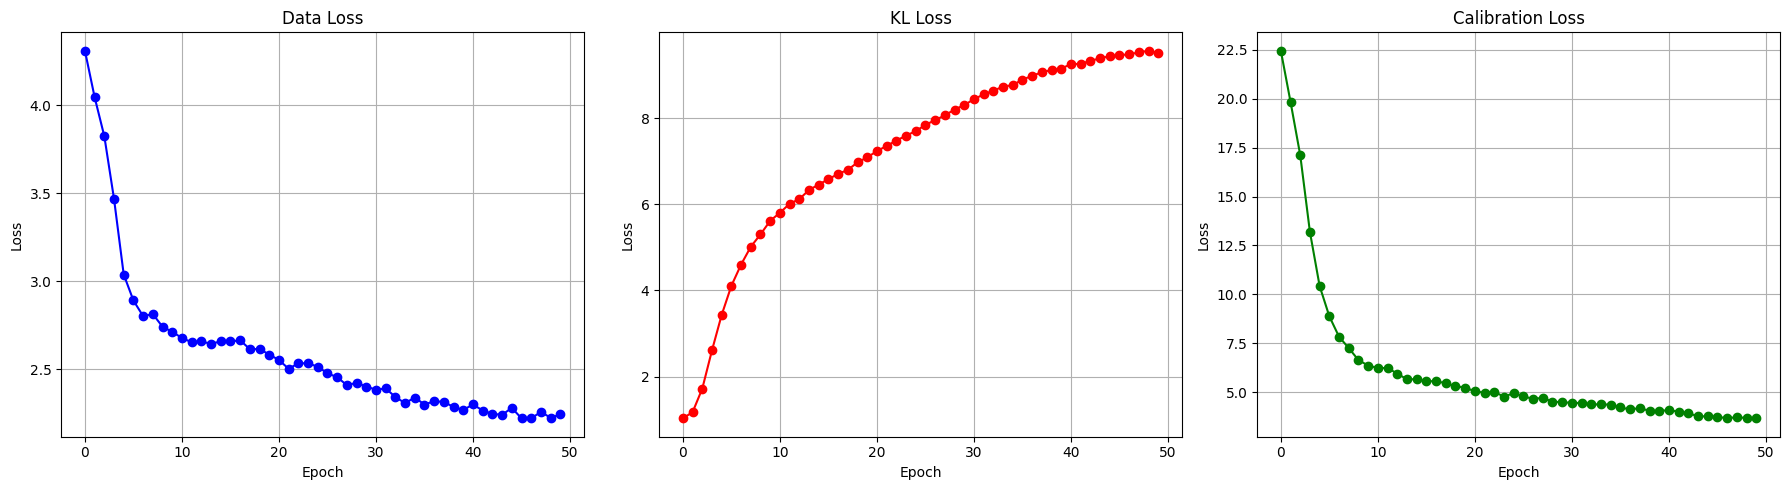

In [172]:
plot_loss_development(epoch_data_loss, epoch_kl_loss, epoch_calibration_loss)

In [188]:
for epoch in range(epochs):
    
    # Training Phase
    model.train()
    batch_loss = []
    batch_data_loss = []
    batch_kl_loss = []
    batch_calibration_loss = []

    for x, y in train_loader:

        optimizer.zero_grad()

        # Perform multiple forward passes
        y_pred_list = []
        for _ in range(n_forward_passes):
            y_pred = model(x)
            y_pred_list.append(y_pred)
        
        # Compute mean and std for predictions
        y_pred_mean = torch.mean(torch.stack(y_pred_list), dim=0)
        pred_std = torch.std(torch.stack(y_pred_list), dim=0)

        # Compute data loss (e.g., RMSE)
        data_loss = data_loss_function(y_pred_mean, y)

        # Compute KL divergence loss
        kl = kl_loss_function(model)

        # Compute calibration loss (TCE)
        calibration_loss = calibration_loss_function(y_pred_mean, pred_std, y)

        # Total loss = data loss + weighted KL loss + weighted calibration loss
        loss = data_loss + kl_weight * kl + calibration_loss_weight * calibration_loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Append batch losses
        batch_loss.append(loss.item())
        batch_data_loss.append(data_loss.item())
        batch_kl_loss.append(kl.item())
        batch_calibration_loss.append(calibration_loss.item())

    # Calculate and store epoch losses (mean of batch losses)
    epoch_loss.append(np.mean(batch_loss))
    epoch_data_loss.append(np.mean(batch_data_loss))
    epoch_kl_loss.append(np.mean(batch_kl_loss))
    epoch_calibration_loss.append(np.mean(batch_calibration_loss))

    print('Epoch:', epoch, 'Training Loss:', epoch_loss[-1], 'Data Loss:', epoch_data_loss[-1], 
          'Calibration Loss:', epoch_calibration_loss[-1], 'KL Loss:', epoch_kl_loss[-1])

    # Validation Phase (only data and calibration loss, no KL loss)
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    with torch.no_grad():  # Disable gradient calculation
        y_pred_list_val = []
        for _ in range(n_forward_passes):
            y_pred_val = model(x_val_scaled_tensor)
            y_pred_list_val.append(y_pred_val)

        # Compute mean and std for predictions (validation)
        y_pred_mean_val = torch.mean(torch.stack(y_pred_list_val), dim=0)
        pred_std_val = torch.std(torch.stack(y_pred_list_val), dim=0)

        # Calculate data loss and calibration loss for validation set
        val_data_loss = data_loss_function(y_pred_mean_val, y_val_tensor)
        val_calibration_loss = calibration_loss_function(y_pred_mean_val, pred_std_val, y_val_tensor)

        val_data_loss_list.append(val_data_loss.item())
        val_calibration_loss_list.append(val_calibration_loss.item())

        print('Epoch:', epoch, 'Validation Data Loss:', val_data_loss_list[-1], 
              'Validation Calibration Loss:', val_calibration_loss_list[-1])

Epoch: 0 Training Loss: 6.7462302762269974 Data Loss: 4.3321008098125455 Calibration Loss: 24.03453227251768 KL Loss: 1.0676188489794731
Epoch: 0 Validation Data Loss: 7.725454330444336 Validation Calibration Loss: 56.40078353881836
Epoch: 1 Training Loss: 6.096293814182282 Data Loss: 4.045833671092987 Calibration Loss: 20.388805125802755 KL Loss: 1.157957512140274
Epoch: 1 Validation Data Loss: 7.6667890548706055 Validation Calibration Loss: 55.386695861816406
Epoch: 2 Training Loss: 5.795547842979431 Data Loss: 3.9168963941931723 Calibration Loss: 18.640365267544986 KL Loss: 1.4614934521913527
Epoch: 2 Validation Data Loss: 7.295348167419434 Validation Calibration Loss: 49.174163818359375
Epoch: 3 Training Loss: 5.07430804848671 Data Loss: 3.5657619449496267 Calibration Loss: 14.86118849813938 KL Loss: 2.2427237606048585
Epoch: 3 Validation Data Loss: 6.852461338043213 Validation Calibration Loss: 42.20622634887695
Epoch: 4 Training Loss: 4.3499942922592165 Data Loss: 3.1601549282670

In [196]:
def plot_loss_curves(epoch_data_loss, epoch_calibration_loss, epoch_kl_loss, val_data_loss_list=None, val_calibration_loss_list=None):
    """
    Plots the data loss, calibration loss, and KL loss for training (and validation if provided) over epochs.
    
    Parameters:
    epoch_data_loss (list): List of training data losses.
    epoch_calibration_loss (list): List of training calibration losses.
    epoch_kl_loss (list): List of KL losses for training.
    val_data_loss_list (list, optional): List of validation data losses.
    val_calibration_loss_list (list, optional): List of validation calibration losses.
    """
    # Create a figure with 3 subplots
    plt.figure(figsize=(21, 5))

    # Plot Data Loss (Training vs Validation, if provided)
    plt.subplot(1, 3, 1)
    plt.plot(epoch_data_loss, label='Training Data Loss', marker='o', linestyle='-', color='b')
    if val_data_loss_list is not None:
        plt.plot(val_data_loss_list, label='Validation Data Loss', marker='o', linestyle='--', color='r')
    plt.title('Data Loss (Training' + (' vs Validation' if val_data_loss_list is not None else '') + ')')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Calibration Loss (Training vs Validation, if provided)
    plt.subplot(1, 3, 2)
    plt.plot(epoch_calibration_loss, label='Training Calibration Loss', marker='o', linestyle='-', color='g')
    if val_calibration_loss_list is not None:
        plt.plot(val_calibration_loss_list, label='Validation Calibration Loss', marker='o', linestyle='--', color='orange')
    plt.title('Calibration Loss (Training' + (' vs Validation' if val_calibration_loss_list is not None else '') + ')')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot KL Loss (Training only)
    plt.subplot(1, 3, 3)
    plt.plot(epoch_kl_loss, label='KL Loss (Training)', marker='o', linestyle='-', color='purple')
    plt.title('KL Loss (Training)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



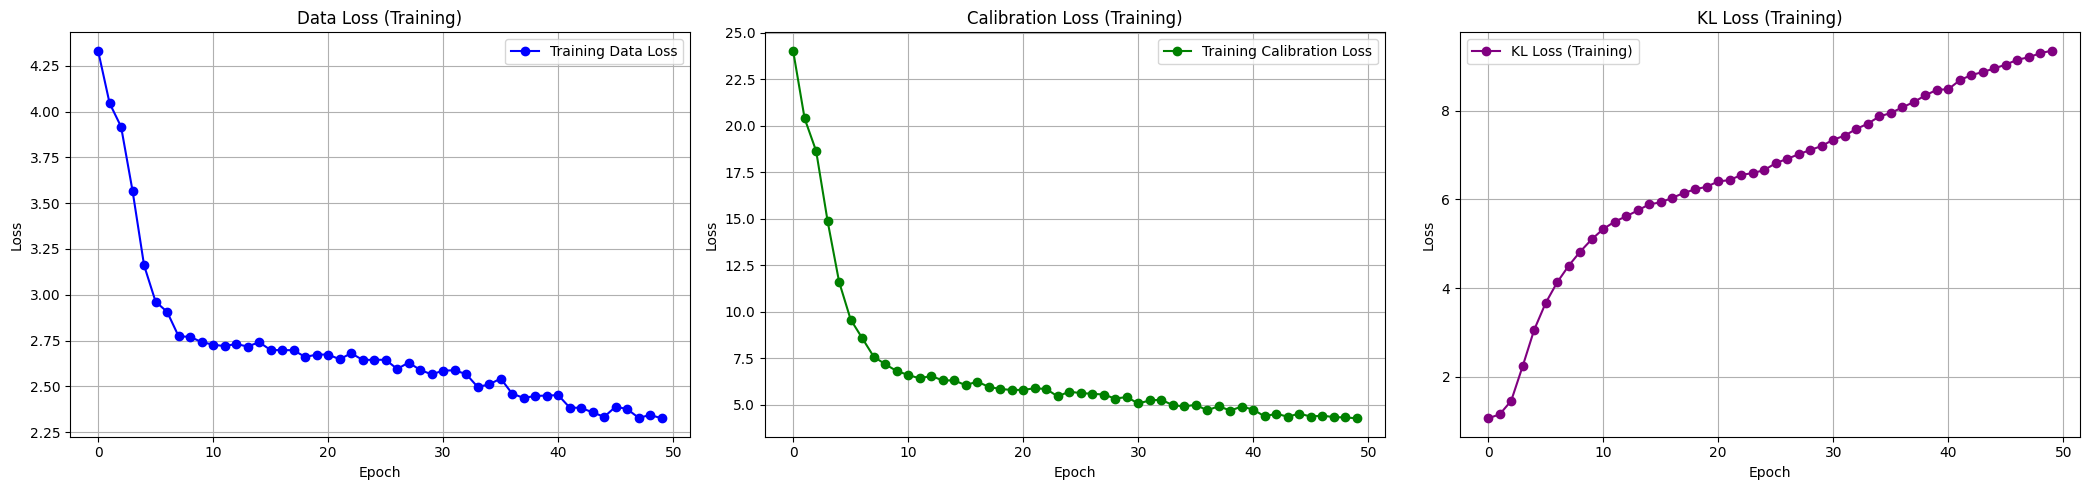

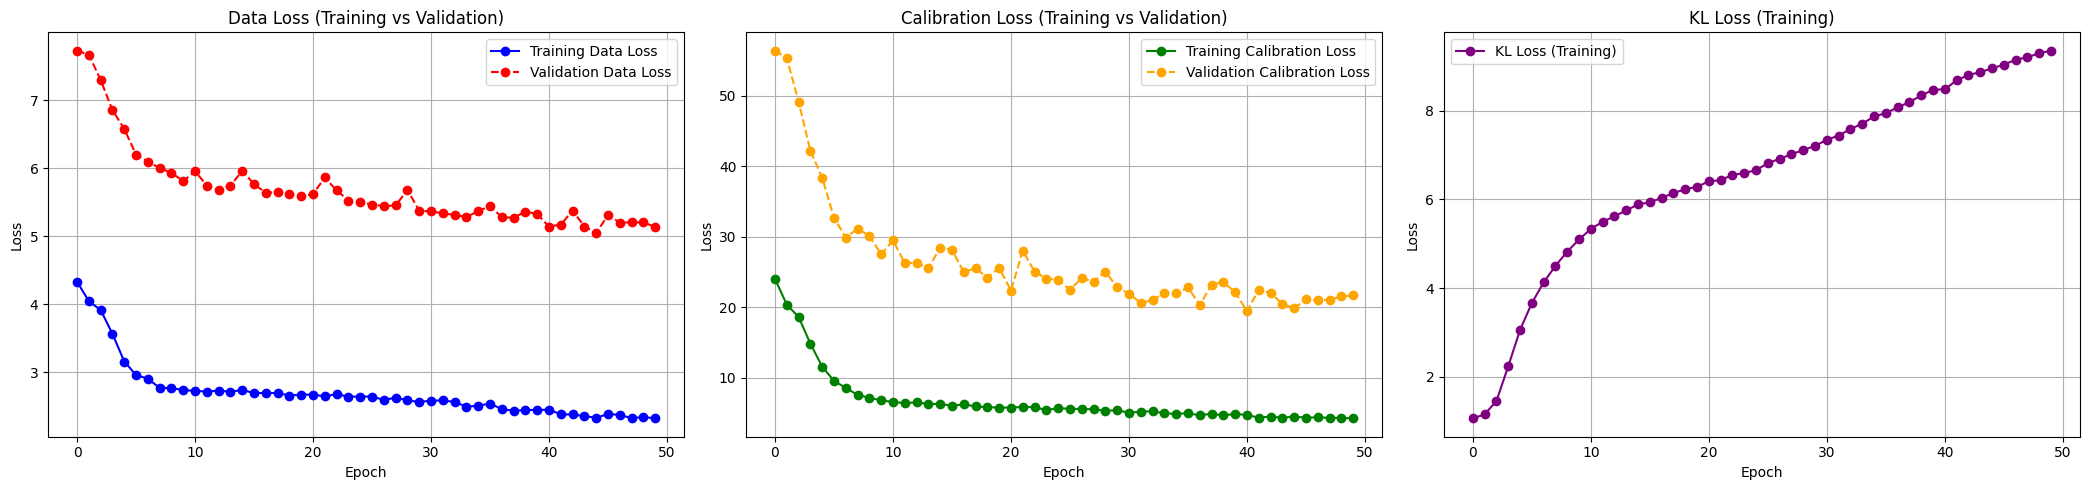

In [198]:
# Call the function to plot the loss curves after training
plot_loss_curves(epoch_data_loss, epoch_calibration_loss, epoch_kl_loss)
plot_loss_curves(epoch_data_loss, epoch_calibration_loss, epoch_kl_loss, val_data_loss_list, val_calibration_loss_list)

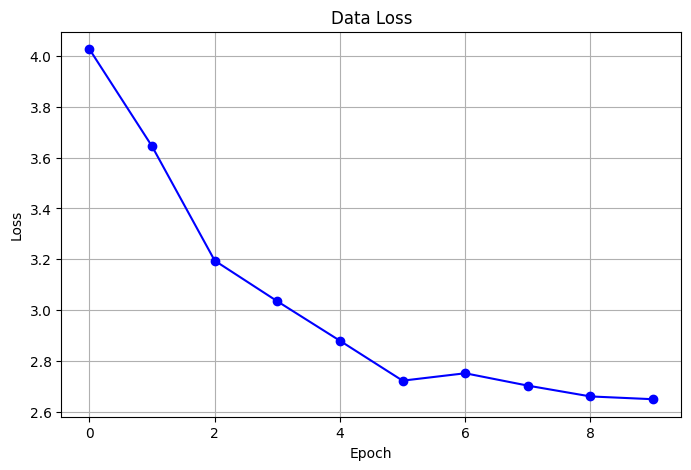

In [50]:

# loss_list=epoch_data_loss #SELECT

# # Plotting the loss 
# plt.figure(figsize=(8, 5))
# plt.plot(loss_list, marker='o', linestyle='-', color='b')
# plt.title('Data Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True)
# plt.show()

In [14]:
# #saving the whole model
# torch.save(model, 'trainedModels\\'+model_name+'.pth')

## 4. Model evaluation
    


In [173]:
## load a model

# model = torch.load('trainedModels\\'+model_name+'.pth')
model.eval() # sets the model to evaluation mode, which affects layers like dropout and batch normalization that behave differently during training and inference.
model

Sequential(
  (0): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=16, out_features=20, bias=True)
  (1): ReLU()
  (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=20, out_features=1, bias=True)
  (5): ReLU()
)

In [174]:
from plotting import plot_true_vs_pred, single_para_strudy_perf
from MLmodel import bnn_predict_with_uncertainty, calculate_rmse, filter_values_within_range, calculate_mape, calculate_custom_loss, evaluate_model_performance

### On training data



In [175]:
# make predictions and caluclate mean 
##### make predictions ####3
# Define number of predictions
n_predictions = 1000
# Perfrom multiple predictions on data --> get mean and std for each data point
y_train_mean_pred_np, y_train_std_pred_np, y_train_pred_n_times = bnn_predict_with_uncertainty(model, x_train_scaled_tensor, n=n_predictions, log_transform_back=False)

In [176]:
def evaluate_model(y_true, y_pred):
    """
    Evaluates model performance by calculating RMSE, MAPE for different ranges
    and custom loss. Updates eval_dict with the computed values.

    Parameters:
    y_true (numpy array): True values of the target variable.
    y_pred (numpy array): Predicted values of the target variable.

    Returns:
    eval_dict: Updated evaluation dictionary with RMSE, MAPE and custom loss metrics.
    """
    eval_dict={}
    # All data
    rmse_train_all = calculate_rmse(y_true=y_true, y_pred=y_pred)
    eval_dict['rmse_all'] = rmse_train_all
    mape_train_all = calculate_mape(y_true, y_pred)
    eval_dict['mape_all'] = mape_train_all

    # Critical range 1 (0.5 - 1.5)
    filtered_y_np, filtered_y_pred_np = filter_values_within_range(y_true=y_true, y_pred=y_pred, lb=0.5, ub=1.5)
    rmse_crit1 = calculate_rmse(filtered_y_np, filtered_y_pred_np)
    eval_dict['rmse_crit1'] = rmse_crit1
    mape_crit1 = calculate_mape(filtered_y_np, filtered_y_pred_np)
    eval_dict['mape_crit1'] = mape_crit1

    # Critical range 2 (1.5 - 3)
    filtered_y_np, filtered_y_pred_np = filter_values_within_range(y_true=y_true, y_pred=y_pred, lb=1.5, ub=3)
    rmse_crit2 = calculate_rmse(filtered_y_np, filtered_y_pred_np)
    eval_dict['rmse_crit2'] = rmse_crit2
    mape_crit2 = calculate_mape(filtered_y_np, filtered_y_pred_np)
    eval_dict['mape_crit2'] = mape_crit2

    # Critical range 3 (3 - 10)
    filtered_y_np, filtered_y_pred_np = filter_values_within_range(y_true=y_true, y_pred=y_pred, lb=3, ub=10)
    rmse_crit3 = calculate_rmse(filtered_y_np, filtered_y_pred_np)
    eval_dict['rmse_crit3'] = rmse_crit3
    mape_crit3 = calculate_mape(filtered_y_np, filtered_y_pred_np)
    eval_dict['mape_crit3'] = mape_crit3

    # Critical range 4 (10 - 500)
    filtered_y_np, filtered_y_pred_np = filter_values_within_range(y_true=y_true, y_pred=y_pred, lb=10, ub=500)
    rmse_crit4 = calculate_rmse(filtered_y_np, filtered_y_pred_np)
    eval_dict['rmse_crit4'] = rmse_crit4
    mape_crit4 = calculate_mape(filtered_y_np, filtered_y_pred_np)
    eval_dict['mape_crit4'] = mape_crit4

    # Custom loss
    custom_loss = calculate_custom_loss(y_true=y_true, y_pred=y_pred, threshold=0.5, alpha=1, beta=1)
    eval_dict['custom'] = custom_loss

    return eval_dict

In [177]:
evaluate_model(y_true=y_train_np, y_pred=y_train_mean_pred_np)

{'rmse_all': 2.5609116030016152,
 'mape_all': 45.14178040185516,
 'rmse_crit1': 0.7500330347568859,
 'mape_crit1': 48.903097697741934,
 'rmse_crit2': 1.1481065659440208,
 'mape_crit2': 35.918890946521884,
 'rmse_crit3': 3.208056969170335,
 'mape_crit3': 40.35392142877818,
 'rmse_crit4': 9.874035940050328,
 'mape_crit4': 35.88741031151883,
 'custom': 0.44995095260931794}

Expected Calibration Error (ECE): 0.05867918622848198
Total Calibration Error (TCE): 5.867918622848197
Calibration Bias: -5.555555555555552


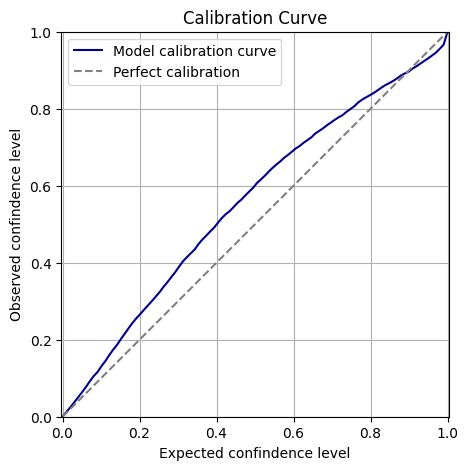

In [178]:
from MLmodel import evaluate_confidence_levels, calc_uncertainty_callibaration_metrics, plot_uncertainty_callibaration_curve

exp_conf, obs_conf= evaluate_confidence_levels(y_train_np, y_train_mean_pred_np, 
                                               y_train_std_pred_np, 
                                               n_confidence_levels=100)

ece, tce, bias =calc_uncertainty_callibaration_metrics(exp_conf, obs_conf,verbalise=True)

plot_uncertainty_callibaration_curve(exp_conf, obs_conf )

### on validation set

In [179]:
##### make predictions ####
# Define number of predictions
n_predictions = 1000

# Perfrom multiple predictions on data --> get mean and std for each data point
y_val_mean_pred_np, y_val_std_pred_np, y_val_pred_n_times = bnn_predict_with_uncertainty(model, x_val_scaled_tensor, n=n_predictions,log_transform_back=False)


In [180]:

evaluate_model(y_true=y_val_np, y_pred=y_val_mean_pred_np)

{'rmse_all': 4.97881440219237,
 'mape_all': 44.74559267513654,
 'rmse_crit1': 0.6384459736726957,
 'mape_crit1': 46.637663796407445,
 'rmse_crit2': 1.5786380474679385,
 'mape_crit2': 46.85559117001588,
 'rmse_crit3': 3.080839232605867,
 'mape_crit3': 40.59826623389553,
 'rmse_crit4': 16.866228612751758,
 'mape_crit4': 37.17079670879534,
 'custom': 0.4474559267513654}

Expected Calibration Error (ECE): 0.03728144228144226
Total Calibration Error (TCE): 3.7281442281442265
Calibration Bias: -2.7702702702702666


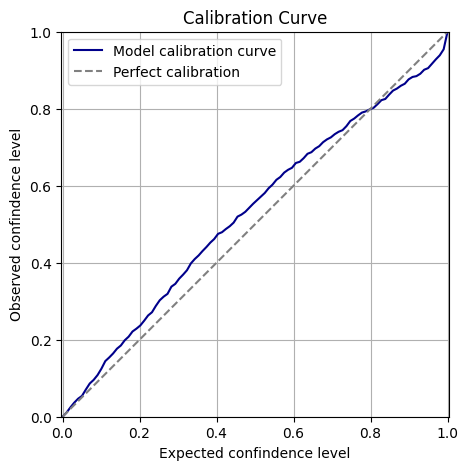

In [181]:
from MLmodel import evaluate_confidence_levels, calc_uncertainty_callibaration_metrics, plot_uncertainty_callibaration_curve

exp_conf, obs_conf= evaluate_confidence_levels(y_val_np, y_val_mean_pred_np, 
                                               y_val_std_pred_np, 
                                               n_confidence_levels=100)

ece, tce, bias =calc_uncertainty_callibaration_metrics(exp_conf, obs_conf, verbalise=True)
plot_uncertainty_callibaration_curve(exp_conf, obs_conf )

# Svaing Eval Dict

In [30]:
# import json

# #naming
# #dict_name='Studie_1_Sophia'
# # dict_name='Combined_Study'

# # Saving the dictionary to a JSON file
# with open('trainedModels\\{}.json'.format(dict_name), 'w') as file:
#     json.dump(eval_dict, file, indent=4)